Accuracy: 0.992


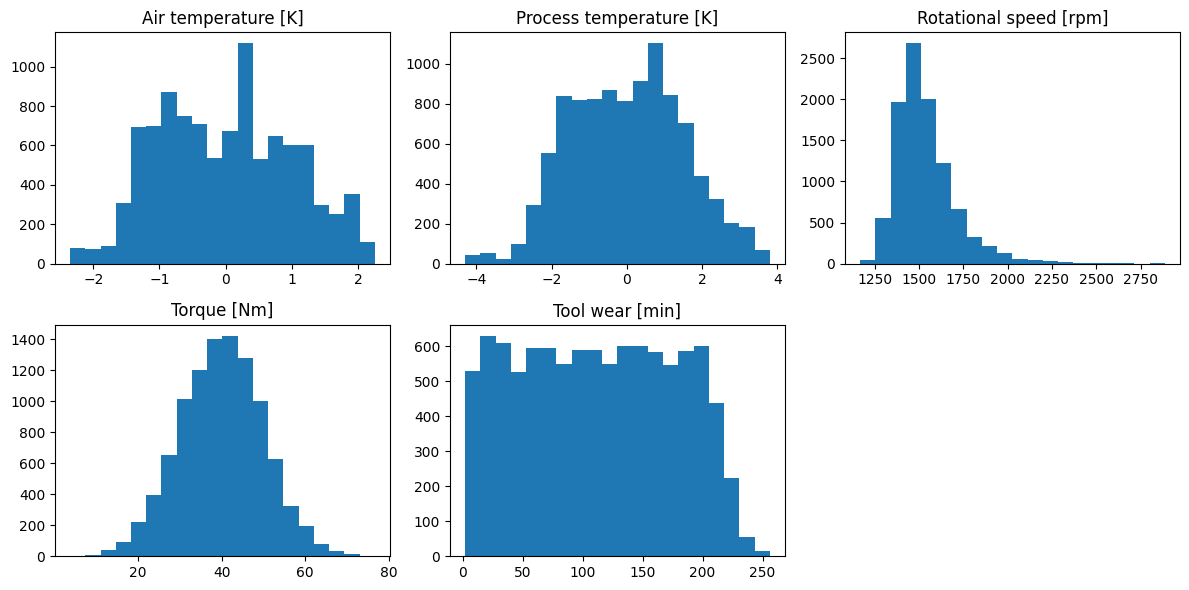

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1528
        True       1.00      0.97      0.98       472

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
[[1527    1]
 [  15  457]]
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9907499999999999
Cross-Validation Scores: [0.990625 0.991875 0.991875 0.990625 0.98875 ]
Feature Importances: [0.01120766 0.00980576 0.48260649 0.09896318 0.39741691]


['predictive_maintenance_model.pkl']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Step 1: Load the data
data = pd.read_csv('/content/ai4i2020.csv')

# Step 2: Data Preprocessing
# Normalize air temperature and process temperature
data['Air temperature [K]'] = (data['Air temperature [K]'] - 300) / 2
data['Process temperature [K]'] = (data['Process temperature [K]'] - 310) / 1

# Ensure torque values are within the specified range
data['Torque [Nm]'] = data['Torque [Nm]'].clip(lower=0)

# Calculate tool wear based on product quality variants
tool_wear_map = {'L': 5, 'M': 3, 'H': 2}
data['Tool wear [min]'] = data.apply(lambda row: row['Tool wear [min]'] + tool_wear_map[row['Product ID'][0]], axis=1)

# Create 'machine failure' label based on failure modes
data['Machine failure'] = ((data['Tool wear [min]'] >= 200) & (data['Tool wear [min]'] <= 240)) | \
                          ((data['Air temperature [K]'] - data['Process temperature [K]'] < 8.6) & (data['Rotational speed [rpm]'] < 1380)) | \
                          ((data['Torque [Nm]'] * data['Rotational speed [rpm]'] / 9.55 < 3500) | (data['Torque [Nm]'] * data['Rotational speed [rpm]'] / 9.55 > 9000)) | \
                          ((data['Tool wear [min]'] * data['Torque [Nm]'] > 11000) & (data['Product ID'] == 'L') |
                           (data['Tool wear [min]'] * data['Torque [Nm]'] > 12000) & (data['Product ID'] == 'M') |
                           (data['Tool wear [min]'] * data['Torque [Nm]'] > 13000) & (data['Product ID'] == 'H')) | \
                          (data['UDI'] % 1000 < 10)

# Step 3: Feature Selection
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = data[features]
y = data['Machine failure']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train the model (Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Step 7: Data Visualization
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[feature], bins=20)
    plt.title(feature)
plt.tight_layout()
plt.show()

# Step 8: Model Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 9: Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Step 10: Cross-Validation
cv_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)

# Step 11: Model Interpretation (Feature Importances)
feature_importances = model.feature_importances_
print("Feature Importances:", feature_importances)

# Step 12: Model Deployment
joblib.dump(model, 'predictive_maintenance_model.pkl')




In [ ]:
import joblib

# Load the saved model
loaded_model = joblib.load('predictive_maintenance_model.pkl')

# Use the loaded model to make predictions
predictions = loaded_model.predict(X_test)
